Load Original Data

In [1]:
# load data
import pandas as pd
import time
start_time = time.time()   
from datetime import datetime
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Start Time =", current_time)
#windows_filepath = 'E:/Dropbox/Machine Learning/Data/Ouyang/20200708/labelDataOffset.csv'
# mac_filepath = '/Users/jiahuali1991/Dropbox/Machine Learning/Data/Ouyang/20200708/labelDataOffset.csv'
windows_filepath = 'D:/labelDataOffset.csv'
df = pd.read_csv(windows_filepath,header=None)
print("--- %s seconds ---" % (time.time() - start_time))
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("End Time =", current_time)

Start Time = 21:42:12
--- 26.29075813293457 seconds ---
End Time = 21:42:38


Fourier Transformation 

In [2]:
import time
start_time = time.time()   
from datetime import datetime
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Start Time =", current_time)

# concatenate alternating columns with pandas
df1 = df.iloc[:,:256]
df1
df2 = df.iloc[:,256:512]
df2

df_new = pd.DataFrame()
for i in range(len(df2.columns)):
    df_new[df1.columns[i]]=df1[df1.columns[i]]
    df_new[df2.columns[i]]=df2[df2.columns[i]]

df_new
df_new.shape


# make X to complex numpy array
import numpy as np
X_reshape = np.array(df_new).reshape(464780,1,256,2)
complex_df = np.apply_along_axis(lambda args: [complex(*args)], 3, X_reshape)
complex_df_reshape = complex_df.reshape(464780,256)

# Fast Fourier Transformation
from scipy.fftpack import fft
ft_df = fft(complex_df_reshape)
ft_real = pd.DataFrame(ft_df.real)
ft_imag = pd.DataFrame(ft_df.imag)
X_full = pd.concat([ft_real, ft_imag],axis=1)

X_full
X_full.to_csv('D:/Dropbox/Machine Learning/Data/Ouyang/20200708/labelDataOffset_fft.csv', index=False)

print("--- %s seconds ---" % (time.time() - start_time))
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("End Time =", current_time)

Start Time = 21:46:15
--- 978.1732649803162 seconds ---
End Time = 22:02:34


Load Fourier Transformed Data

In [2]:
import time
start_time = time.time()   
from datetime import datetime
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Start Time =", current_time)

# load fft transformed data
import pandas as pd
#windows_filepath_fft = 'E:/Dropbox/Machine Learning/Data/Ouyang/20200708/labelDataOffset_fft.csv'
windows_filepath_fft = 'D:/labelDataOffset_fft.csv'
df_fft = pd.read_csv(windows_filepath_fft,header=0)

print("--- %s seconds ---" % (time.time() - start_time))
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("End Time =", current_time)

Start Time = 21:43:21
--- 37.72626280784607 seconds ---
End Time = 21:43:58


In [3]:
# Original Data
X = df.iloc[:,:512]
y = df[512]
#print(X.describe())
# print(X.shape)

# get unique value for the label
import numpy as np
#np.unique(y)
#print(y.describe())

# FFT
# split features (X) and lables (y)
X_fft = df_fft
#print(X_fft.describe())
#print(X_fft.shape)

Standardize the Data and Split data into training and testing sets

In [5]:
import time
start_time = time.time()   
from datetime import datetime
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Start Time =", current_time)

# split training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_fft_train, X_fft_test, y_train, y_test = train_test_split(X_fft, y, test_size=0.33, random_state=42)
y_train = y_train - 1
y_test = y_test -1

# standardize the data as z-scores
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

print("--- %s seconds ---" % (time.time() - start_time))
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("End Time =", current_time)

Start Time = 21:47:36
--- 4.12438702583313 seconds ---
End Time = 21:47:40


Random Forest

In [9]:
# building Random Forest model on original data
import time
start_time = time.time()   
from datetime import datetime
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Start Time =", current_time)

import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier

print('start fitting Random Forest Model')    

param_dist={
    'criterion':['gini', 'entropy'],
    'max_depth':randint(1, 30),
    'n_estimators': randint(1, 1000),
    'min_samples_split':randint(1, 20),
    'min_samples_leaf':randint(1, 20),
    'max_features':randint(1, 20),
    'max_leaf_nodes':randint(1, 20)
    
}

rf_cv = RandomizedSearchCV(RandomForestClassifier(),param_dist,cv=5,scoring='f1',verbose=10, n_jobs=-1, n_iter=10)

# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[('scaler', StandardScaler()),
                              ('random_search', rf_cv)
                             ])

my_pipeline.fit(X_train, y_train)



Start Time = 21:58:47
start fitting Random Forest Model
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
C:\ProgramData\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 25.3min
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed: 31.5min
[Parallel(n_jobs=-1)]: Done  25 out of  50 | elapsed: 49.5min remaining: 49.5min
[Parallel(n_jobs=-1)]: Done  31 out of  50 | elapsed: 63.4min remaining: 38.8min
[Parallel(n_jobs=-1)]: Done  37 out of  50 | elapsed: 63.4min remaining: 22.3min
[Parallel(n_jobs=-1)]: Done  43 out of  50 | elapsed: 63.4min remaining: 10.3min


ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

In [10]:
print('start making prediction') 

# use the best hyper parameters to build the model
rf_clf = RandomForestClassifier(rf_cv.best_estimator_)

# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[('scaler', StandardScaler()),
                              ('clf', rf_clf)
                             ])

# Preprocessing of training data, fit model 
my_pipeline.fit(X_train, y_train)
y_train_pred = my_pipeline.predict(X_train)
y_pred = my_pipeline.predict(X_test)



print('start calculating accuracy score') 


# Preprocessing of training data, fit model 
my_pipeline.fit(X_train, y_train)
y_train_pred = my_pipeline.predict(X_train)
y_pred = my_pipeline.predict(X_test)

from sklearn.metrics import accuracy_score
print('training set model accuracy = ', accuracy_score(y_train, y_train_pred))

from sklearn.metrics import f1_score
print('training set model f1 score = ', f1_score(y_train, y_train_pred))

from sklearn.metrics import accuracy_score
print('testing set model accuracy = ', accuracy_score(y_test, y_pred))

from sklearn.metrics import f1_score
print('testing set model f1 score = ', f1_score(y_test, y_pred))


from sklearn.metrics import classification_report
print('testing set model classification report : \n ', classification_report(y_test, y_pred))


# save the model to disk
print('saving model to disk') 
import joblib
#filename = 'E:/Dropbox/Machine Learning/Data/Ouyang/20200708/RandomForest_labelDataOffset_20200920.sav'
filename = 'D:/RandomForest_labelDataOffset_20200920.sav'
joblib.dump(rf_clf, filename)

print("--- %s seconds ---" % (time.time() - start_time))
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("End Time =", current_time)

start making prediction


AttributeError: 'RandomizedSearchCV' object has no attribute 'best_estimator_'

In [9]:
# building Random Forest model on FFT data
import time
start_time = time.time()   
from datetime import datetime
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Start Time =", current_time)
print('start fitting Random Forest Model')    
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_jobs=-1)
rf_clf.fit(X_fft_train, y_train)
print('start making prediction') 
y_test_pred_rf = rf_clf.predict(X_fft_test)

from sklearn.metrics import accuracy_score  
print("Random Forest Model Accuracy: %.2f%%" % (accuracy_score(y_test, y_test_pred_rf) * 100.0))

from sklearn.metrics import f1_score
print("F1 Score: %.2f%%" % (f1_score(y_test, y_test_pred_rf, average='macro') * 100.0))

# save the model to disk
print('saving model to disk')
import joblib
# filename = 'E:/Dropbox/Machine Learning/Data/Ouyang/20200708/RandomForest_labelDataOffset_fft.sav'
filename = 'D:/RandomForest_labelDataOffset_fft.sav'
joblib.dump(rf_clf, filename)

print("--- %s seconds ---" % (time.time() - start_time))
now = datetime.now()
current_time = now.strftime("%H:%M:%S")

Start Time = 21:24:21
start fitting Random Forest Model
start making prediction
Random Forest Model Accuracy: 65.15%
F1 Score: 64.31%
--- 112.51878380775452 seconds ---


KNN Model

In [7]:
# KNN on original data
import time
start_time = time.time()   
from datetime import datetime
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Start Time =", current_time)
print('start fitting KNN Model')    
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_jobs = -1) 
knn_clf.fit(X_train, y_train)
print('start making prediction') 
y_test_pred_knn = knn_clf.predict(X_test)
print('start calculating accuracy score') 

from sklearn.metrics import accuracy_score  
knn_accuracy = accuracy_score(y_test, y_test_pred_knn)
print("KNN Model Accuracy: %.2f%%" % (knn_accuracy * 100.0))

from sklearn.metrics import f1_score
print("F1 Score: %.2f%%" % (f1_score(y_test, y_test_pred_knn, average='macro') * 100.0))

# save the model to disk
import joblib
filename = 'D:/KNN_labelDataOffset.sav'
joblib.dump(knn_clf, filename)
print("--- %s seconds ---" % (time.time() - start_time))
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("End Time =", current_time)

Start Time = 19:08:24
start fitting KNN Model
start making prediction
start calculating accuracy score
KNN Model Accuracy: 49.68%
F1 Score: 48.87%
--- 140.80306243896484 seconds ---
End Time = 19:10:45


In [8]:
# KNN on FFT data
import time
start_time = time.time()   
from datetime import datetime
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Start Time =", current_time)
print('start fitting KNN Model')    
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_jobs = -1) 
knn_clf.fit(X_fft_train, y_train)
print('start making prediction') 
y_test_pred_knn = knn_clf.predict(X_fft_test)
print('start calculating accuracy score') 
from sklearn.metrics import accuracy_score  
knn_accuracy = accuracy_score(y_test, y_test_pred_knn)
print("KNN Model Accuracy: %.2f%%" % (knn_accuracy * 100.0))

from sklearn.metrics import f1_score
print("F1 Score: %.2f%%" % (f1_score(y_test, y_test_pred_knn, average='macro') * 100.0))

# save the model to disk
import joblib
filename = 'D:/KNN_labelDataOffset_fft.sav'
joblib.dump(knn_clf, filename)
print("--- %s seconds ---" % (time.time() - start_time))
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("End Time =", current_time)

Start Time = 19:11:29
start fitting KNN Model
start making prediction
start calculating accuracy score
KNN Model Accuracy: 57.42%
F1 Score: 56.45%
--- 429.53593254089355 seconds ---
End Time = 19:18:38


Support Vector Machine

In [5]:
# Support Vector Machine on original data
import time
start_time = time.time()   
from datetime import datetime
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Start Time =", current_time)
print('start fitting Support Vector Machine Model')    
from sklearn.svm import LinearSVC
svm_clf = LinearSVC()
svm_clf.fit(X_train, y_train)
print('start making prediction') 
y_test_pred_svm = svm_clf.predict(X_test)
print('start calculating accuracy score') 
from sklearn.metrics import accuracy_score  
svm_accuracy = accuracy_score(y_test, y_test_pred_svm)
print("Support Vector Machine Model Accuracy: %.2f%%" % (svm_accuracy * 100.0))
from sklearn.metrics import f1_score
print("F1 Score: %.2f%%" % (f1_score(y_test, y_test_pred_svm, average='macro') * 100.0))
# save the model to disk
import joblib
# filename = 'E:/Dropbox/Machine Learning/Data/Ouyang/20200708/SVM_labelDataOffset.sav'
filename = 'D:/SVM_labelDataOffset.sav'
joblib.dump(svm_clf, filename)
print("--- %s seconds ---" % (time.time() - start_time))
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("End Time =", current_time)

Start Time = 21:42:05
start fitting Support Vector Machine Model


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


start making prediction
start calculating accuracy score
Support Vector Machine Model Accuracy: 18.21%


NameError: name 'y_test_pred_rf' is not defined

In [7]:
from sklearn.metrics import f1_score
print("F1 Score: %.2f%%" % (f1_score(y_test, y_test_pred_svm, average='macro') * 100.0))
import joblib
filename = 'D:/SVM_labelDataOffset.sav'
joblib.dump(svm_clf, filename)

F1 Score: 9.01%


['D:/SVM_labelDataOffset.sav']

In [ ]:
# Support Vector Machine on FFT data
import time
start_time = time.time()   
from datetime import datetime
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Start Time =", current_time)
print('start fitting Support Vector Machine Model')    
from sklearn.svm import LinearSVC
svm_clf = LinearSVC()
svm_clf.fit(X_fft_train, y_train)
print('start making prediction') 
y_test_pred_svm = svm_clf.predict(X_fft_test)
print('start calculating accuracy score') 
from sklearn.metrics import accuracy_score  
svm_accuracy = accuracy_score(y_test, y_test_pred_svm)
print("Support Vector Machine Model Accuracy: %.2f%%" % (svm_accuracy * 100.0))
from sklearn.metrics import f1_score
print("F1 Score: %.2f%%" % (f1_score(y_test, y_test_pred_svm, average='macro') * 100.0))
# save the model to disk
import joblib
# filename = 'E:/Dropbox/Machine Learning/Data/Ouyang/20200708/SVM_labelDataOffset_fft.sav'
filename = 'D:/SVM_labelDataOffset_fft.sav'
joblib.dump(svm_clf, filename)
print("--- %s seconds ---" % (time.time() - start_time))
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("End Time =", current_time)

Start Time = 23:56:39
start fitting Support Vector Machine Model


deep learning

Start Time = 10:08:55
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_8 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_9 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_11 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_12 (Dense)             (No

Epoch 48/500
311402/311402 [==============================] - 9s 30us/sample - loss: 0.6721 - acc: 0.7258 - val_loss: 0.7248 - val_acc: 0.7073
Epoch 49/500
311402/311402 [==============================] - 9s 30us/sample - loss: 0.6692 - acc: 0.7263 - val_loss: 0.7394 - val_acc: 0.7023
Epoch 50/500
311402/311402 [==============================] - 9s 30us/sample - loss: 0.6675 - acc: 0.7277 - val_loss: 0.7291 - val_acc: 0.7061
Epoch 51/500
311402/311402 [==============================] - 9s 30us/sample - loss: 0.6635 - acc: 0.7294 - val_loss: 0.7353 - val_acc: 0.7043
Epoch 52/500
311402/311402 [==============================] - 9s 30us/sample - loss: 0.6644 - acc: 0.7295 - val_loss: 0.7261 - val_acc: 0.7072
Epoch 53/500
311402/311402 [==============================] - 9s 30us/sample - loss: 0.6582 - acc: 0.7325 - val_loss: 0.7436 - val_acc: 0.7028
Epoch 54/500
311402/311402 [==============================] - 9s 30us/sample - loss: 0.6590 - acc: 0.7311 - val_loss: 0.7172 - val_acc: 0.7143

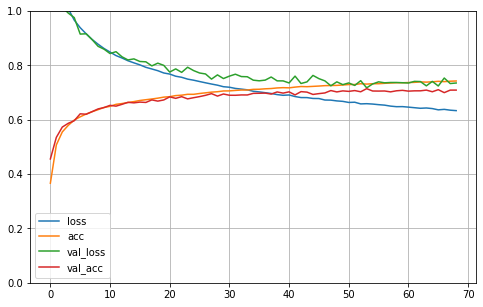

--- 643.024576663971 seconds ---
End Time = 10:19:38


In [10]:
# deep learning on original data
import time
start_time = time.time()   
from datetime import datetime
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Start Time =", current_time)

import tensorflow as tf
from tensorflow import keras
tf.__version__
keras.__version__

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[512,]))
model.add(keras.layers.Dense(512, activation="relu"))
model.add(keras.layers.Dense(256, activation="relu"))
model.add(keras.layers.Dense(128, activation="relu"))
model.add(keras.layers.Dense(64, activation="relu"))
model.add(keras.layers.Dense(32, activation="relu"))
model.add(keras.layers.Dense(16, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

print(model.summary())

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"]) # sgd

filepath = 'D:/DeepNet_Model_labelDataOffset_original_20200916.h5'
# model.load_weights(filepath) #load previously trained model


history = model.fit(X_train, y_train, epochs=500, batch_size = 128,
                    validation_data=(X_test, y_test),
                   callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, verbose=0, mode='auto')
    ])

# we re-load the best weights once training is finished
#model.load_weights(filepath)

import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

# model.evaluate(X_fft_test, y_test)

print("--- %s seconds ---" % (time.time() - start_time))
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("End Time =", current_time)

Start Time = 21:27:56
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_15 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_16 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_17 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_18 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_19 (Dense)             (No

Epoch 48/500
311402/311402 [==============================] - 9s 29us/sample - loss: 0.5666 - acc: 0.7688 - val_loss: 0.6813 - val_acc: 0.7321
Epoch 49/500
311402/311402 [==============================] - 9s 29us/sample - loss: 0.5654 - acc: 0.7695 - val_loss: 0.7049 - val_acc: 0.7261
Epoch 50/500
311402/311402 [==============================] - 9s 29us/sample - loss: 0.5635 - acc: 0.7709 - val_loss: 0.6782 - val_acc: 0.7355
Epoch 51/500
311402/311402 [==============================] - 9s 29us/sample - loss: 0.5587 - acc: 0.7721 - val_loss: 0.6999 - val_acc: 0.7264
Epoch 52/500
311402/311402 [==============================] - 9s 29us/sample - loss: 0.5585 - acc: 0.7731 - val_loss: 0.6800 - val_acc: 0.7357
Epoch 53/500
311402/311402 [==============================] - 9s 28us/sample - loss: 0.5563 - acc: 0.7734 - val_loss: 0.6866 - val_acc: 0.7339
Epoch 54/500
311402/311402 [==============================] - 9s 29us/sample - loss: 0.5533 - acc: 0.7754 - val_loss: 0.6987 - val_acc: 0.7269

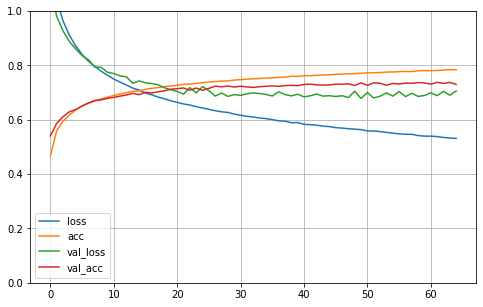

--- 583.2183651924133 seconds ---
End Time = 21:37:39


In [17]:
# deep learning on fft tranformed data
import time
start_time = time.time()   
from datetime import datetime
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Start Time =", current_time)

import tensorflow as tf
from tensorflow import keras
tf.__version__
keras.__version__

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[512]))
model.add(keras.layers.Dense(512, activation="relu"))
model.add(keras.layers.Dense(256, activation="relu"))
model.add(keras.layers.Dense(128, activation="relu"))
model.add(keras.layers.Dense(64, activation="relu"))
model.add(keras.layers.Dense(32, activation="relu"))
model.add(keras.layers.Dense(16, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

print(model.summary())

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"]) # sgd

filepath = 'E:/Dropbox/Machine Learning/Data/Ouyang/20200708/DeepNet_Model_labelDataOffset_fft.h5'
# model.load_weights(filepath) #load previously trained model


history = model.fit(X_fft_train, y_train, epochs=500, batch_size = 128,
                    validation_data=(X_fft_test, y_test),
                   callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, verbose=0, mode='auto')
    ])

# we re-load the best weights once training is finished
model.load_weights(filepath)

import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

y_test_pred_dl = model.predict(X_test)
# model.evaluate(X_fft_test, y_test)

print("--- %s seconds ---" % (time.time() - start_time))
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("End Time =", current_time)

Random Forest Model

Classification and Regression Trees (CART)

In [5]:
# Classification and Regression Trees (CART) on origianl data
import time
start_time = time.time()   
from datetime import datetime
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Start Time =", current_time)

print('start fitting CART Model')    
from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(random_state=0)
dt_clf.fit(X_train, y_train)
print('start making prediction') 
y_test_pred_dt = dt_clf.predict(X_test)
print('start calculating accuracy score') 
from sklearn.metrics import accuracy_score  
dt_accuracy = accuracy_score(y_test, y_test_pred_dt)
print("CART Model Accuracy: %.2f%%" % (dt_accuracy * 100.0))
from sklearn.metrics import f1_score
print("F1 Score: %.2f%%" % (f1_score(y_test, y_test_pred_dt, average='macro') * 100.0))

# save the model to disk
import joblib
filename = 'D:/CART_labelDataOffset.sav'
joblib.dump(dt_clf, filename)
print("--- %s seconds ---" % (time.time() - start_time))
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("End Time =", current_time)

Start Time = 22:47:57
start fitting CART Model
start making prediction
start calculating accuracy score
CART Model Accuracy: 45.00%
F1 Score: 44.06%
--- 512.3880906105042 seconds ---
End Time = 22:56:30


In [6]:
# Classification and Regression Trees (CART) on FFT data
import time
start_time = time.time()   
from datetime import datetime
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Start Time =", current_time)

print('start fitting CART Model')    
from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(random_state=0)
dt_clf.fit(X_fft_train, y_train)
print('start making prediction') 
y_test_pred_dt = dt_clf.predict(X_fft_test)
print('start calculating accuracy score') 
from sklearn.metrics import accuracy_score  
dt_accuracy = accuracy_score(y_test, y_test_pred_dt)
print("CART Model Accuracy: %.2f%%" % (dt_accuracy * 100.0))
from sklearn.metrics import f1_score
print("F1 Score: %.2f%%" % (f1_score(y_test, y_test_pred_dt, average='macro') * 100.0))

# save the model to disk
import joblib
filename = 'D:/CART_labelDataOffset_fft.sav'
joblib.dump(dt_clf, filename)
print("--- %s seconds ---" % (time.time() - start_time))
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("End Time =", current_time)

Start Time = 22:56:30
start fitting CART Model
start making prediction
start calculating accuracy score
CART Model Accuracy: 53.73%
F1 Score: 52.78%
--- 364.16675543785095 seconds ---
End Time = 23:02:34


Naive Bayes

In [9]:
# Naive Bayes on original data
import time
start_time = time.time()   
from datetime import datetime
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Start Time =", current_time)
print('start fitting Gaussian Naive Bayes Model')    
from sklearn.naive_bayes import GaussianNB
gnb_clf = GaussianNB()
gnb_clf.fit(X_train, y_train)
print('start making prediction') 
y_test_pred_gnb = gnb_clf.predict(X_test)
print('start calculating accuracy score') 
from sklearn.metrics import accuracy_score  
gnb_accuracy = accuracy_score(y_test, y_test_pred_gnb)
print("Gaussian Naive Bayes Model Accuracy: %.2f%%" % (gnb_accuracy * 100.0))
from sklearn.metrics import f1_score
print("F1 Score: %.2f%%" % (f1_score(y_test, y_test_pred_gnb, average='macro') * 100.0))

# save the model to disk
import joblib
filename = 'D:/Naive_Bayes_labelDataOffset.sav'
joblib.dump(dt_clf, filename)

print("--- %s seconds ---" % (time.time() - start_time))
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("End Time =", current_time)

Start Time = 23:05:09
start fitting Gaussian Naive Bayes Model
start making prediction
start calculating accuracy score
Gaussian Naive Bayes Model Accuracy: 15.85%
F1 Score: 5.35%
--- 10.416738986968994 seconds ---
End Time = 23:05:19


In [10]:
# Naive Bayes on FFT data
import time
start_time = time.time()   
from datetime import datetime
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Start Time =", current_time)
print('start fitting Gaussian Naive Bayes Model')    
from sklearn.naive_bayes import GaussianNB
gnb_clf = GaussianNB()
gnb_clf.fit(X_fft_train, y_train)
print('start making prediction') 
y_test_pred_gnb = gnb_clf.predict(X_fft_test)
print('start calculating accuracy score') 
from sklearn.metrics import accuracy_score  
gnb_accuracy = accuracy_score(y_test, y_test_pred_gnb)
print("Gaussian Naive Bayes Model Accuracy: %.2f%%" % (gnb_accuracy * 100.0))
from sklearn.metrics import f1_score
print("F1 Score: %.2f%%" % (f1_score(y_test, y_test_pred_gnb, average='macro') * 100.0))

# save the model to disk
import joblib
filename = 'D:/Naive_Bayes_labelDataOffset_fft.sav'
joblib.dump(dt_clf, filename)

print("--- %s seconds ---" % (time.time() - start_time))
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("End Time =", current_time)

Start Time = 23:05:19
start fitting Gaussian Naive Bayes Model
start making prediction
start calculating accuracy score
Gaussian Naive Bayes Model Accuracy: 16.61%
F1 Score: 15.78%
--- 9.952740907669067 seconds ---
End Time = 23:05:29


Logistic Regression

In [8]:
# Logistic Regression on original data
import time
start_time = time.time()   
from datetime import datetime
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Start Time =", current_time)

print('start fitting Logistic Regression Model')    
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression(random_state=0)
lr_clf.fit(X_train, y_train)
print('start making prediction') 
y_test_pred_lr = lr_clf.predict(X_test)
print('start calculating accuracy score') 
from sklearn.metrics import accuracy_score  
lr_accuracy = accuracy_score(y_test, y_test_pred_lr)
print("Logistic Regression Model Accuracy: %.2f%%" % (lr_accuracy * 100.0))
from sklearn.metrics import f1_score
print("F1 Score: %.2f%%" % (f1_score(y_test, y_test_pred_lr, average='macro') * 100.0))

# save the model to disk
import joblib
filename = 'D:/Logistic_Regression_labelDataOffset.sav'
joblib.dump(dt_clf, filename)

print("--- %s seconds ---" % (time.time() - start_time))
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("End Time =", current_time)

Start Time = 23:03:19
start fitting Logistic Regression Model


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


start making prediction
start calculating accuracy score
Logistic Regression Model Accuracy: 17.79%
F1 Score: 3.28%
--- 44.9066686630249 seconds ---
End Time = 23:04:04


In [7]:
# Logistic Regression on FFT data
import time
start_time = time.time()   
from datetime import datetime
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Start Time =", current_time)

print('start fitting Logistic Regression Model')    
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression(random_state=0)
lr_clf.fit(X_fft_train, y_train)
print('start making prediction') 
y_test_pred_lr = lr_clf.predict(X_fft_test)
print('start calculating accuracy score') 
from sklearn.metrics import accuracy_score  
lr_accuracy = accuracy_score(y_test, y_test_pred_lr)
print("Logistic Regression Model Accuracy: %.2f%%" % (lr_accuracy * 100.0))
from sklearn.metrics import f1_score
print("F1 Score: %.2f%%" % (f1_score(y_test, y_test_pred_lr, average='macro') * 100.0))

# save the model to disk
import joblib
filename = 'D:/Logistic_Regression_labelDataOffset_fft.sav'
joblib.dump(dt_clf, filename)


print("--- %s seconds ---" % (time.time() - start_time))
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("End Time =", current_time)

Start Time = 23:02:34
start fitting Logistic Regression Model


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


start making prediction
start calculating accuracy score
Logistic Regression Model Accuracy: 17.75%
F1 Score: 3.85%
--- 44.99318814277649 seconds ---
End Time = 23:03:19


SGD Model

In [11]:
# SGD on original data
import time
start_time = time.time()   
from datetime import datetime
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Start Time =", current_time)
print('start fitting SGD Model') 
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier()
sgd_clf.fit(X_train, y_train)
print('start making prediction') 
y_test_pred_sgd = sgd_clf.predict(X_test)
print('start calculating accuracy score') 
from sklearn.metrics import accuracy_score  
sgd_accuracy = accuracy_score(y_test, y_test_pred_sgd)
print("SGD Model Accuracy: %.2f%%" % (sgd_accuracy * 100.0))
from sklearn.metrics import f1_score
print("F1 Score: %.2f%%" % (f1_score(y_test, y_test_pred_sgd, average='macro') * 100.0))

# save the model to disk
import joblib
filename = 'D:/SGD_labelDataOffset.sav'
joblib.dump(dt_clf, filename)

print("--- %s seconds ---" % (time.time() - start_time))
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("End Time =", current_time)

Start Time = 23:06:03
start fitting SGD Model
start making prediction
start calculating accuracy score
SGD Model Accuracy: 16.87%
F1 Score: 8.84%
--- 138.28463339805603 seconds ---
End Time = 23:08:22


In [12]:
# SGD on FFT data
import time
start_time = time.time()   
from datetime import datetime
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Start Time =", current_time)
print('start fitting SGD Model') 
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier()
sgd_clf.fit(X_fft_train, y_train)
print('start making prediction') 
y_test_pred_sgd = sgd_clf.predict(X_fft_test)
print('start calculating accuracy score') 
from sklearn.metrics import accuracy_score  
sgd_accuracy = accuracy_score(y_test, y_test_pred_sgd)
print("SGD Model Accuracy: %.2f%%" % (sgd_accuracy * 100.0))
from sklearn.metrics import f1_score
print("F1 Score: %.2f%%" % (f1_score(y_test, y_test_pred_sgd, average='macro') * 100.0))

# save the model to disk
import joblib
filename = 'D:/SGD_labelDataOffset_fft.sav'
joblib.dump(dt_clf, filename)

print("--- %s seconds ---" % (time.time() - start_time))
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("End Time =", current_time)

Start Time = 23:08:22
start fitting SGD Model
start making prediction
start calculating accuracy score
SGD Model Accuracy: 16.45%
F1 Score: 10.30%
--- 151.35439276695251 seconds ---
End Time = 23:10:53


Light GBM 

In [14]:
# Light GBM on original data
import time
start_time = time.time()   
from datetime import datetime
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Start Time =", current_time)
print('start fitting Light GBM Model') 
import lightgbm as lgb
lgbm = lgb.LGBMClassifier()
lgbm.fit(X_train, y_train)
print('start making prediction') 
y_test_pred_lgbm = lgbm.predict(X_test)
print('start calculating accuracy score') 
lgbm_accuracy = accuracy_score(y_test, y_test_pred_lgbm)
print("Light GBM Model Accuracy: %.2f%%" % (lgbm_accuracy * 100.0))
from sklearn.metrics import f1_score
print("F1 Score: %.2f%%" % (f1_score(y_test, y_test_pred_lgbm, average='macro') * 100.0))

# save the model to disk
import joblib
filename = 'D:/LightGBM_labelDataOffset.sav'
joblib.dump(lgbm, filename)

print("--- %s seconds ---" % (time.time() - start_time))
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("End Time =", current_time)

Start Time = 23:11:52
start fitting Light GBM Model
start making prediction
start calculating accuracy score
Light GBM Model Accuracy: 45.82%
F1 Score: 42.70%
--- 155.86398148536682 seconds ---
End Time = 23:14:28


In [20]:
# Light GBM on TTF data
import time
start_time = time.time()   
from datetime import datetime
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Start Time =", current_time)
print('start fitting Light GBM Model') 
import lightgbm as lgb
lgbm = lgb.LGBMClassifier()
lgbm.fit(X_fft_train, y_train)
print('start making prediction') 
y_test_pred_lgbm = lgbm.predict(X_fft_test)
print('start calculating accuracy score') 
lgbm_accuracy = accuracy_score(y_test, y_test_pred_lgbm)
print("Light GBM Model Accuracy: %.2f%%" % (lgbm_accuracy * 100.0))
from sklearn.metrics import f1_score
print("F1 Score: %.2f%%" % (f1_score(y_test, y_test_pred_lgbm, average='macro') * 100.0))

# save the model to disk
import joblib
filename = 'D:/LightGBM_labelDataOffset_fft.sav'
joblib.dump(lgbm, filename)

print("--- %s seconds ---" % (time.time() - start_time))
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("End Time =", current_time)

Start Time = 01:50:24
start fitting Light GBM Model
start making prediction
start calculating accuracy score
Light GBM Model Accuracy: 60.32%
F1 Score: 59.49%
--- 182.4669382572174 seconds ---
End Time = 01:53:27


XGBoost

In [16]:
# XGBoost on original data
import time
start_time = time.time()   
from datetime import datetime
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Start Time =", current_time)
print('start fitting XGBoost Model') 
from xgboost import XGBClassifier
XGB_clf = XGBClassifier()
XGB_clf.fit(X_train, y_train)
print('start making prediction') 
y_test_pred_XGB = XGB_clf.predict(X_test)
print('start calculating accuracy score') 
XGB_accuracy = accuracy_score(y_test, y_test_pred_XGB)
print("XGBoost Model Accuracy: %.2f%%" % (XGB_accuracy * 100.0))
from sklearn.metrics import f1_score
print("F1 Score: %.2f%%" % (f1_score(y_test, y_test_pred_XGB, average='macro') * 100.0))

# save the model to disk
import joblib
filename = 'D:/XGB_labelDataOffset.sav'
joblib.dump(XGB_clf, filename)

print("--- %s seconds ---" % (time.time() - start_time))
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("End Time =", current_time)

Start Time = 23:21:01
start fitting XGBoost Model
start making prediction
start calculating accuracy score
XGBoost Model Accuracy: 51.00%
F1 Score: 48.96%
--- 2131.554897069931 seconds ---
End Time = 23:56:32


In [17]:
# XGBoost on FFT data
import time
start_time = time.time()   
from datetime import datetime
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Start Time =", current_time)
print('start fitting XGBoost Model') 
from xgboost import XGBClassifier
XGB_clf = XGBClassifier()
XGB_clf.fit(X_fft_train, y_train)
print('start making prediction') 
y_test_pred_XGB = XGB_clf.predict(X_fft_test)
print('start calculating accuracy score') 
XGB_accuracy = accuracy_score(y_test, y_test_pred_XGB)
print("XGBoost Model Accuracy: %.2f%%" % (XGB_accuracy * 100.0))
from sklearn.metrics import f1_score
print("F1 Score: %.2f%%" % (f1_score(y_test, y_test_pred_XGB, average='macro') * 100.0))

# save the model to disk
import joblib
filename = 'D:/XGB_labelDataOffset_fft.sav'
joblib.dump(XGB_clf, filename)

print("--- %s seconds ---" % (time.time() - start_time))
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("End Time =", current_time)

Start Time = 23:56:32
start fitting XGBoost Model
start making prediction
start calculating accuracy score
XGBoost Model Accuracy: 64.02%
F1 Score: 63.26%
--- 2161.2715220451355 seconds ---
End Time = 00:32:33


CatBoost

In [18]:
# CatBoost on original data
import time
start_time = time.time()   
from datetime import datetime
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Start Time =", current_time)
import time
start_time = time.time() 
print('start fitting CatBoost Model') 
from catboost import CatBoostClassifier
catb_clf = CatBoostClassifier()
catb_clf.fit(X_train, y_train, verbose=1)
print('start making prediction') 
y_test_pred_catb = catb_clf.predict(X_test)
from sklearn.metrics import accuracy_score
print('start calculating accuracy score') 
catb_accuracy = accuracy_score(y_test, y_test_pred_catb)
print("Cat Boost Model Accuracy: %.2f%%" % (catb_accuracy * 100.0))
from sklearn.metrics import f1_score
print("F1 Score: %.2f%%" % (f1_score(y_test, y_test_pred_catb, average='macro') * 100.0))

# save the model to disk
import joblib
filename = 'D:/CatBoost_labelDataOffset.sav'
joblib.dump(catb_clf, filename)

print("--- %s seconds ---" % (time.time() - start_time))
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("End Time =", current_time)

Start Time = 00:32:33
start fitting CatBoost Model
Learning rate set to 0.106043
0:	learn: 2.2226952	total: 2.42s	remaining: 40m 16s
1:	learn: 2.1635928	total: 4.81s	remaining: 40m 1s
2:	learn: 2.1140214	total: 7.17s	remaining: 39m 42s
3:	learn: 2.0692515	total: 9.49s	remaining: 39m 24s
4:	learn: 2.0192828	total: 11.8s	remaining: 39m 15s
5:	learn: 1.9656698	total: 14.2s	remaining: 39m 15s
6:	learn: 1.9356997	total: 16.6s	remaining: 39m 10s
7:	learn: 1.9113236	total: 18.9s	remaining: 38m 58s
8:	learn: 1.8863056	total: 21.3s	remaining: 39m 2s
9:	learn: 1.8471827	total: 23.7s	remaining: 39m 3s
10:	learn: 1.8276087	total: 26s	remaining: 39m
11:	learn: 1.7965561	total: 28.4s	remaining: 38m 59s
12:	learn: 1.7747214	total: 30.8s	remaining: 38m 57s
13:	learn: 1.7515820	total: 33.2s	remaining: 38m 58s
14:	learn: 1.7281660	total: 35.5s	remaining: 38m 51s
15:	learn: 1.7135890	total: 37.9s	remaining: 38m 49s
16:	learn: 1.6924892	total: 40.2s	remaining: 38m 45s
17:	learn: 1.6873569	total: 42.5s	rem

152:	learn: 1.4031003	total: 5m 55s	remaining: 32m 49s
153:	learn: 1.4018677	total: 5m 58s	remaining: 32m 48s
154:	learn: 1.4016692	total: 6m	remaining: 32m 45s
155:	learn: 1.4012910	total: 6m 2s	remaining: 32m 43s
156:	learn: 1.4006836	total: 6m 5s	remaining: 32m 41s
157:	learn: 1.4001870	total: 6m 7s	remaining: 32m 39s
158:	learn: 1.3997289	total: 6m 9s	remaining: 32m 36s
159:	learn: 1.3990417	total: 6m 12s	remaining: 32m 34s
160:	learn: 1.3985701	total: 6m 14s	remaining: 32m 32s
161:	learn: 1.3970402	total: 6m 17s	remaining: 32m 30s
162:	learn: 1.3965564	total: 6m 19s	remaining: 32m 28s
163:	learn: 1.3961232	total: 6m 21s	remaining: 32m 25s
164:	learn: 1.3938534	total: 6m 24s	remaining: 32m 24s
165:	learn: 1.3933395	total: 6m 26s	remaining: 32m 21s
166:	learn: 1.3929405	total: 6m 28s	remaining: 32m 19s
167:	learn: 1.3922513	total: 6m 31s	remaining: 32m 16s
168:	learn: 1.3901298	total: 6m 33s	remaining: 32m 15s
169:	learn: 1.3890133	total: 6m 35s	remaining: 32m 12s
170:	learn: 1.3883

302:	learn: 1.2954471	total: 11m 49s	remaining: 27m 12s
303:	learn: 1.2950491	total: 11m 52s	remaining: 27m 10s
304:	learn: 1.2948613	total: 11m 54s	remaining: 27m 7s
305:	learn: 1.2946246	total: 11m 56s	remaining: 27m 5s
306:	learn: 1.2934582	total: 11m 59s	remaining: 27m 3s
307:	learn: 1.2928212	total: 12m 1s	remaining: 27m 1s
308:	learn: 1.2922661	total: 12m 3s	remaining: 26m 58s
309:	learn: 1.2919701	total: 12m 6s	remaining: 26m 56s
310:	learn: 1.2917005	total: 12m 8s	remaining: 26m 54s
311:	learn: 1.2912506	total: 12m 10s	remaining: 26m 51s
312:	learn: 1.2906786	total: 12m 13s	remaining: 26m 49s
313:	learn: 1.2902416	total: 12m 15s	remaining: 26m 47s
314:	learn: 1.2887134	total: 12m 18s	remaining: 26m 44s
315:	learn: 1.2884426	total: 12m 20s	remaining: 26m 42s
316:	learn: 1.2881278	total: 12m 22s	remaining: 26m 40s
317:	learn: 1.2878285	total: 12m 25s	remaining: 26m 37s
318:	learn: 1.2871108	total: 12m 27s	remaining: 26m 35s
319:	learn: 1.2868120	total: 12m 29s	remaining: 26m 33s


450:	learn: 1.2308986	total: 17m 32s	remaining: 21m 20s
451:	learn: 1.2307167	total: 17m 34s	remaining: 21m 18s
452:	learn: 1.2305083	total: 17m 36s	remaining: 21m 15s
453:	learn: 1.2302892	total: 17m 38s	remaining: 21m 13s
454:	learn: 1.2297399	total: 17m 41s	remaining: 21m 10s
455:	learn: 1.2296585	total: 17m 43s	remaining: 21m 8s
456:	learn: 1.2293302	total: 17m 45s	remaining: 21m 6s
457:	learn: 1.2288196	total: 17m 47s	remaining: 21m 3s
458:	learn: 1.2282795	total: 17m 50s	remaining: 21m 1s
459:	learn: 1.2280972	total: 17m 52s	remaining: 20m 58s
460:	learn: 1.2278816	total: 17m 54s	remaining: 20m 56s
461:	learn: 1.2273969	total: 17m 57s	remaining: 20m 54s
462:	learn: 1.2272094	total: 17m 59s	remaining: 20m 51s
463:	learn: 1.2270916	total: 18m 1s	remaining: 20m 49s
464:	learn: 1.2268956	total: 18m 3s	remaining: 20m 46s
465:	learn: 1.2263291	total: 18m 6s	remaining: 20m 44s
466:	learn: 1.2262088	total: 18m 8s	remaining: 20m 42s
467:	learn: 1.2257626	total: 18m 10s	remaining: 20m 39s


598:	learn: 1.1863317	total: 23m 9s	remaining: 15m 29s
599:	learn: 1.1862226	total: 23m 11s	remaining: 15m 27s
600:	learn: 1.1860657	total: 23m 13s	remaining: 15m 25s
601:	learn: 1.1856752	total: 23m 15s	remaining: 15m 22s
602:	learn: 1.1854952	total: 23m 18s	remaining: 15m 20s
603:	learn: 1.1851648	total: 23m 20s	remaining: 15m 18s
604:	learn: 1.1849869	total: 23m 22s	remaining: 15m 15s
605:	learn: 1.1846295	total: 23m 24s	remaining: 15m 13s
606:	learn: 1.1844913	total: 23m 27s	remaining: 15m 11s
607:	learn: 1.1841920	total: 23m 29s	remaining: 15m 8s
608:	learn: 1.1841324	total: 23m 31s	remaining: 15m 6s
609:	learn: 1.1840415	total: 23m 34s	remaining: 15m 4s
610:	learn: 1.1838029	total: 23m 36s	remaining: 15m 1s
611:	learn: 1.1836631	total: 23m 38s	remaining: 14m 59s
612:	learn: 1.1832702	total: 23m 40s	remaining: 14m 57s
613:	learn: 1.1831543	total: 23m 43s	remaining: 14m 54s
614:	learn: 1.1829983	total: 23m 45s	remaining: 14m 52s
615:	learn: 1.1826177	total: 23m 47s	remaining: 14m 4

746:	learn: 1.1505554	total: 28m 46s	remaining: 9m 44s
747:	learn: 1.1504060	total: 28m 49s	remaining: 9m 42s
748:	learn: 1.1503091	total: 28m 51s	remaining: 9m 40s
749:	learn: 1.1502550	total: 28m 53s	remaining: 9m 37s
750:	learn: 1.1498184	total: 28m 56s	remaining: 9m 35s
751:	learn: 1.1496983	total: 28m 58s	remaining: 9m 33s
752:	learn: 1.1495356	total: 29m	remaining: 9m 30s
753:	learn: 1.1491725	total: 29m 2s	remaining: 9m 28s
754:	learn: 1.1490711	total: 29m 5s	remaining: 9m 26s
755:	learn: 1.1489068	total: 29m 7s	remaining: 9m 23s
756:	learn: 1.1488074	total: 29m 9s	remaining: 9m 21s
757:	learn: 1.1486715	total: 29m 11s	remaining: 9m 19s
758:	learn: 1.1485344	total: 29m 14s	remaining: 9m 17s
759:	learn: 1.1482867	total: 29m 16s	remaining: 9m 14s
760:	learn: 1.1479661	total: 29m 18s	remaining: 9m 12s
761:	learn: 1.1475179	total: 29m 21s	remaining: 9m 10s
762:	learn: 1.1473841	total: 29m 23s	remaining: 9m 7s
763:	learn: 1.1472969	total: 29m 25s	remaining: 9m 5s
764:	learn: 1.147175

897:	learn: 1.1242360	total: 34m 30s	remaining: 3m 55s
898:	learn: 1.1241001	total: 34m 32s	remaining: 3m 52s
899:	learn: 1.1240328	total: 34m 35s	remaining: 3m 50s
900:	learn: 1.1238746	total: 34m 37s	remaining: 3m 48s
901:	learn: 1.1235779	total: 34m 39s	remaining: 3m 45s
902:	learn: 1.1233373	total: 34m 42s	remaining: 3m 43s
903:	learn: 1.1231519	total: 34m 44s	remaining: 3m 41s
904:	learn: 1.1227818	total: 34m 46s	remaining: 3m 39s
905:	learn: 1.1224331	total: 34m 49s	remaining: 3m 36s
906:	learn: 1.1221826	total: 34m 51s	remaining: 3m 34s
907:	learn: 1.1218610	total: 34m 53s	remaining: 3m 32s
908:	learn: 1.1218247	total: 34m 55s	remaining: 3m 29s
909:	learn: 1.1215692	total: 34m 58s	remaining: 3m 27s
910:	learn: 1.1214399	total: 35m	remaining: 3m 25s
911:	learn: 1.1211393	total: 35m 2s	remaining: 3m 22s
912:	learn: 1.1210259	total: 35m 5s	remaining: 3m 20s
913:	learn: 1.1209413	total: 35m 7s	remaining: 3m 18s
914:	learn: 1.1208737	total: 35m 9s	remaining: 3m 15s
915:	learn: 1.1206

In [19]:
# CatBoost on FFT data
import time
start_time = time.time()   
from datetime import datetime
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Start Time =", current_time)
import time
start_time = time.time() 
print('start fitting CatBoost Model') 
from catboost import CatBoostClassifier
catb_clf = CatBoostClassifier()
catb_clf.fit(X_fft_train, y_train, verbose=1)
print('start making prediction') 
y_test_pred_catb = catb_clf.predict(X_fft_test)
from sklearn.metrics import accuracy_score
print('start calculating accuracy score') 
catb_accuracy = accuracy_score(y_test, y_test_pred_catb)
print("Cat Boost Model Accuracy: %.2f%%" % (catb_accuracy * 100.0))
from sklearn.metrics import f1_score
print("F1 Score: %.2f%%" % (f1_score(y_test, y_test_pred_catb, average='macro') * 100.0))

# save the model to disk
import joblib
filename = 'D:/CatBoost_labelDataOffset_fft.sav'
joblib.dump(catb_clf, filename)

print("--- %s seconds ---" % (time.time() - start_time))
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("End Time =", current_time)

Start Time = 01:11:30
start fitting CatBoost Model
Learning rate set to 0.106043
0:	learn: 2.1909824	total: 2.28s	remaining: 38m
1:	learn: 2.0950908	total: 4.64s	remaining: 38m 35s
2:	learn: 2.0216738	total: 6.98s	remaining: 38m 38s
3:	learn: 1.9626268	total: 9.39s	remaining: 38m 57s
4:	learn: 1.9096572	total: 11.7s	remaining: 38m 41s
5:	learn: 1.8604799	total: 13.9s	remaining: 38m 29s
6:	learn: 1.8228597	total: 16.2s	remaining: 38m 23s
7:	learn: 1.7916441	total: 18.5s	remaining: 38m 16s
8:	learn: 1.7619312	total: 20.8s	remaining: 38m 14s
9:	learn: 1.7349077	total: 23.1s	remaining: 38m 6s
10:	learn: 1.7160288	total: 25.3s	remaining: 37m 56s
11:	learn: 1.7000845	total: 27.6s	remaining: 37m 50s
12:	learn: 1.6841629	total: 29.8s	remaining: 37m 42s
13:	learn: 1.6689938	total: 32s	remaining: 37m 34s
14:	learn: 1.6445795	total: 34.3s	remaining: 37m 30s
15:	learn: 1.6317478	total: 36.6s	remaining: 37m 30s
16:	learn: 1.6161475	total: 38.8s	remaining: 37m 25s
17:	learn: 1.6067097	total: 41.1s	r

152:	learn: 1.1717506	total: 5m 48s	remaining: 32m 10s
153:	learn: 1.1688331	total: 5m 51s	remaining: 32m 8s
154:	learn: 1.1665561	total: 5m 53s	remaining: 32m 6s
155:	learn: 1.1658388	total: 5m 55s	remaining: 32m 4s
156:	learn: 1.1643857	total: 5m 57s	remaining: 32m 1s
157:	learn: 1.1631804	total: 6m	remaining: 31m 59s
158:	learn: 1.1627337	total: 6m 2s	remaining: 31m 56s
159:	learn: 1.1599490	total: 6m 4s	remaining: 31m 55s
160:	learn: 1.1575700	total: 6m 7s	remaining: 31m 53s
161:	learn: 1.1553362	total: 6m 9s	remaining: 31m 51s
162:	learn: 1.1548012	total: 6m 11s	remaining: 31m 49s
163:	learn: 1.1542243	total: 6m 14s	remaining: 31m 46s
164:	learn: 1.1530520	total: 6m 16s	remaining: 31m 44s
165:	learn: 1.1516982	total: 6m 18s	remaining: 31m 41s
166:	learn: 1.1510659	total: 6m 20s	remaining: 31m 39s
167:	learn: 1.1498307	total: 6m 23s	remaining: 31m 37s
168:	learn: 1.1483548	total: 6m 25s	remaining: 31m 35s
169:	learn: 1.1479571	total: 6m 27s	remaining: 31m 33s
170:	learn: 1.1462700	

302:	learn: 1.0366917	total: 11m 33s	remaining: 26m 34s
303:	learn: 1.0359920	total: 11m 35s	remaining: 26m 32s
304:	learn: 1.0356790	total: 11m 37s	remaining: 26m 30s
305:	learn: 1.0353811	total: 11m 40s	remaining: 26m 27s
306:	learn: 1.0349340	total: 11m 42s	remaining: 26m 25s
307:	learn: 1.0340878	total: 11m 44s	remaining: 26m 23s
308:	learn: 1.0338219	total: 11m 46s	remaining: 26m 20s
309:	learn: 1.0332685	total: 11m 49s	remaining: 26m 18s
310:	learn: 1.0328830	total: 11m 51s	remaining: 26m 16s
311:	learn: 1.0326923	total: 11m 53s	remaining: 26m 13s
312:	learn: 1.0316686	total: 11m 56s	remaining: 26m 11s
313:	learn: 1.0308944	total: 11m 58s	remaining: 26m 9s
314:	learn: 1.0299307	total: 12m	remaining: 26m 7s
315:	learn: 1.0289988	total: 12m 3s	remaining: 26m 5s
316:	learn: 1.0287620	total: 12m 5s	remaining: 26m 2s
317:	learn: 1.0284551	total: 12m 7s	remaining: 26m
318:	learn: 1.0279953	total: 12m 9s	remaining: 25m 58s
319:	learn: 1.0275574	total: 12m 12s	remaining: 25m 55s
320:	lea

450:	learn: 0.9719311	total: 17m 13s	remaining: 20m 57s
451:	learn: 0.9716832	total: 17m 15s	remaining: 20m 55s
452:	learn: 0.9709622	total: 17m 17s	remaining: 20m 52s
453:	learn: 0.9707266	total: 17m 19s	remaining: 20m 50s
454:	learn: 0.9704449	total: 17m 22s	remaining: 20m 48s
455:	learn: 0.9703222	total: 17m 24s	remaining: 20m 46s
456:	learn: 0.9696409	total: 17m 26s	remaining: 20m 43s
457:	learn: 0.9693282	total: 17m 29s	remaining: 20m 41s
458:	learn: 0.9691793	total: 17m 31s	remaining: 20m 39s
459:	learn: 0.9688585	total: 17m 33s	remaining: 20m 36s
460:	learn: 0.9683815	total: 17m 36s	remaining: 20m 34s
461:	learn: 0.9681829	total: 17m 38s	remaining: 20m 32s
462:	learn: 0.9679887	total: 17m 40s	remaining: 20m 30s
463:	learn: 0.9677103	total: 17m 42s	remaining: 20m 27s
464:	learn: 0.9673850	total: 17m 45s	remaining: 20m 25s
465:	learn: 0.9670663	total: 17m 47s	remaining: 20m 23s
466:	learn: 0.9664268	total: 17m 49s	remaining: 20m 20s
467:	learn: 0.9658702	total: 17m 52s	remaining: 

598:	learn: 0.9281725	total: 22m 54s	remaining: 15m 19s
599:	learn: 0.9278996	total: 22m 56s	remaining: 15m 17s
600:	learn: 0.9276149	total: 22m 58s	remaining: 15m 15s
601:	learn: 0.9273669	total: 23m 1s	remaining: 15m 13s
602:	learn: 0.9272848	total: 23m 3s	remaining: 15m 10s
603:	learn: 0.9268954	total: 23m 5s	remaining: 15m 8s
604:	learn: 0.9264659	total: 23m 8s	remaining: 15m 6s
605:	learn: 0.9261461	total: 23m 10s	remaining: 15m 3s
606:	learn: 0.9257350	total: 23m 12s	remaining: 15m 1s
607:	learn: 0.9252852	total: 23m 15s	remaining: 14m 59s
608:	learn: 0.9249405	total: 23m 17s	remaining: 14m 57s
609:	learn: 0.9248616	total: 23m 19s	remaining: 14m 54s
610:	learn: 0.9245392	total: 23m 21s	remaining: 14m 52s
611:	learn: 0.9242580	total: 23m 24s	remaining: 14m 50s
612:	learn: 0.9239905	total: 23m 26s	remaining: 14m 48s
613:	learn: 0.9238315	total: 23m 28s	remaining: 14m 45s
614:	learn: 0.9235517	total: 23m 31s	remaining: 14m 43s
615:	learn: 0.9231197	total: 23m 33s	remaining: 14m 41s


746:	learn: 0.8945641	total: 28m 35s	remaining: 9m 41s
747:	learn: 0.8943818	total: 28m 38s	remaining: 9m 38s
748:	learn: 0.8942429	total: 28m 40s	remaining: 9m 36s
749:	learn: 0.8939852	total: 28m 42s	remaining: 9m 34s
750:	learn: 0.8936668	total: 28m 45s	remaining: 9m 31s
751:	learn: 0.8934493	total: 28m 47s	remaining: 9m 29s
752:	learn: 0.8933450	total: 28m 49s	remaining: 9m 27s
753:	learn: 0.8930872	total: 28m 52s	remaining: 9m 25s
754:	learn: 0.8928655	total: 28m 54s	remaining: 9m 22s
755:	learn: 0.8926756	total: 28m 56s	remaining: 9m 20s
756:	learn: 0.8923158	total: 28m 59s	remaining: 9m 18s
757:	learn: 0.8918913	total: 29m 1s	remaining: 9m 15s
758:	learn: 0.8915375	total: 29m 3s	remaining: 9m 13s
759:	learn: 0.8912527	total: 29m 6s	remaining: 9m 11s
760:	learn: 0.8909537	total: 29m 8s	remaining: 9m 9s
761:	learn: 0.8908849	total: 29m 10s	remaining: 9m 6s
762:	learn: 0.8907630	total: 29m 12s	remaining: 9m 4s
763:	learn: 0.8906576	total: 29m 15s	remaining: 9m 2s
764:	learn: 0.8904

897:	learn: 0.8676174	total: 34m 24s	remaining: 3m 54s
898:	learn: 0.8674862	total: 34m 26s	remaining: 3m 52s
899:	learn: 0.8673672	total: 34m 28s	remaining: 3m 49s
900:	learn: 0.8672581	total: 34m 31s	remaining: 3m 47s
901:	learn: 0.8672234	total: 34m 33s	remaining: 3m 45s
902:	learn: 0.8670462	total: 34m 35s	remaining: 3m 42s
903:	learn: 0.8669419	total: 34m 38s	remaining: 3m 40s
904:	learn: 0.8667580	total: 34m 40s	remaining: 3m 38s
905:	learn: 0.8665647	total: 34m 42s	remaining: 3m 36s
906:	learn: 0.8665157	total: 34m 45s	remaining: 3m 33s
907:	learn: 0.8661567	total: 34m 47s	remaining: 3m 31s
908:	learn: 0.8660248	total: 34m 49s	remaining: 3m 29s
909:	learn: 0.8659627	total: 34m 51s	remaining: 3m 26s
910:	learn: 0.8658420	total: 34m 54s	remaining: 3m 24s
911:	learn: 0.8654891	total: 34m 56s	remaining: 3m 22s
912:	learn: 0.8652449	total: 34m 58s	remaining: 3m 20s
913:	learn: 0.8651791	total: 35m 1s	remaining: 3m 17s
914:	learn: 0.8650693	total: 35m 3s	remaining: 3m 15s
915:	learn: 

In [30]:
y_test_pred_rf = rf_clf.predict(X_test)
y_test_pred_gbm = gbm.predict(X_test)
y_test_pred_XGB = XGB_clf.predict(X_test)

In [53]:
import numpy as np
y_test_pred_rf = y_test_pred_rf.reshape((153378,1))
y_test_pred_gbm = y_test_pred_gbm.reshape((153378,1))
y_test_pred_XGB = y_test_pred_XGB.reshape((153378,1))
y_combined = np.concatenate((y_test_pred_rf, y_test_pred_gbm, y_test_pred_XGB),axis=1)

In [54]:
y_combined.shape

(153378, 3)

In [61]:
y_combined = pd.DataFrame(y_combined)
y_combined

y_test_pred_rf = pd.DataFrame(y_test_pred_rf)
y_test_pred_rf

,0
0,1
1,8
2,3
3,3
4,1
...,...
153373,3
153374,3
153375,3
153376,8


In [58]:
y_test = pd.DataFrame(y_test)
y_test

,512
285897,3
372128,8
372670,9
305755,6
59454,4
...,...
435624,7
381444,1
340148,0
264688,3


In [93]:
y_combined_new = pd.DataFrame()
for i in range(len(y_test)):
    y_combined['combined_score'][i] = y_test.iloc[i].isin(y_combined.iloc[i])


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [94]:
y_combined

,0,1,2,combined_score
0,1,1,1,"512 False Name: 285897, dtype: bool"
1,8,9,8,"512 True Name: 372128, dtype: bool"
2,3,7,1,"512 False Name: 372670, dtype: bool"
3,3,3,2,"512 False Name: 305755, dtype: bool"
4,1,1,9,"512 False Name: 59454, dtype: bool"
...,...,...,...,...
153373,3,7,8,"512 True Name: 435624, dtype: bool"
153374,3,7,7,"512 False Name: 381444, dtype: bool"
153375,3,7,8,"512 False Name: 340148, dtype: bool"
153376,8,8,4,"512 False Name: 264688, dtype: bool"


In [97]:
y_combined['combined_score'].any==True

#number_of_patients_with_cancer = df.has_cancer[df.has_cancer==True].count()

False

In [71]:
y_combined.iloc[0]

0    1
1    1
2    1
Name: 0, dtype: int64

In [72]:
y_combined

,0,1,2
0,1,1,1
1,8,9,8
2,3,7,1
3,3,3,2
4,1,1,9
...,...,...,...
153373,3,7,8
153374,3,7,7
153375,3,7,8
153376,8,8,4


In [78]:
y_test.iloc[1]

512    8
Name: 372128, dtype: int64

In [79]:
y_test

,512
285897,3
372128,8
372670,9
305755,6
59454,4
...,...
435624,7
381444,1
340148,0
264688,3
